In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

import os
import glob
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

# sns.set(color_codes=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)


In [3]:
n_way = 20
n_shot = 5
n_query = 15
n_examples = 20 # no of exp for each class
im_width, im_height, channels = 84,84,3
h_dim = 64
z_dim = 64


In [5]:
from skimage import transform

def augment(image, k):
    image = transform.rotate(image, angle=k, resize=False, center=None, order=1, mode='constant',
                                  cval=0, clip=True, preserve_range=False)
    return image

In [6]:
data_dir = '/home/ankish/111-courses/ml-project/few-shot/maml_nice/MAML-TensorFlow/miniimagenet/data/'

def collect_img_address(data_dir, main_dir):
    data = []
    classes = glob.glob(data_dir + '/' + main_dir + '/*')
    data_cls = []
    for cls in classes:
        images = glob.glob(cls + '/*')
        data_cls.append(images)
    data.append(data_cls)
    return data

train = collect_img_address(data_dir, 'train')
test = collect_img_address(data_dir, 'test')
val = collect_img_address(data_dir, 'val')

train = np.array(train).reshape(-1,600)
test = np.array(test).reshape(-1,600)
val = np.array(val).reshape(-1,600)
print("classes and its samples for each train, test, val: ")
train.shape, test.shape, val.shape

classes and its samples for each train, test, val: 


((64, 600), (20, 600), (16, 600))

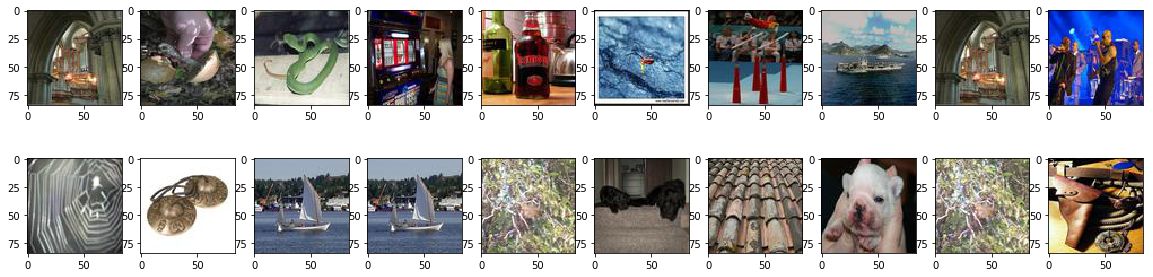

In [7]:
# pick 20 random images from different classes
ids = np.random.randint(0,64,size=(20))
fig, ax = plt.subplots(2,10, figsize=(20,5))
axes = ax.flatten()
for i in range(20):
    axes[i].imshow(Image.open(train[ids[i]][0]))

In [10]:
def get_batch(dataset, n_way, n_shot, n_query):
    n_classes = dataset.shape[0]
    epi_classes = np.random.permutation(n_classes)[:n_way]
    support, query = [], []
    for i, epi_cls in enumerate(epi_classes):
        selected = np.random.permutation(n_examples)[:n_shot + n_query]
        s_files = dataset[epi_cls, selected[:n_shot]]
        q_files = dataset[epi_cls, selected[n_shot:]]

    #     print(epi_cls, selected)
        s_data = []
        for file in s_files:
            img = plt.imread(file)
            s_data.append(img)

        q_data = []
        for file in q_files:
            img = plt.imread(file)
            q_data.append(img)

        support.append(np.array(s_data))
        query.append(np.array(q_data))
        
    support = np.array(support).astype('float')/255.0
    query = np.array(query).astype('float')/255.0
    s_labels = np.tile(np.arange(n_way)[:, np.newaxis], (1, n_shot)).astype(np.uint8)
    q_labels = np.tile(np.arange(n_way)[:, np.newaxis], (1, n_query)).astype(np.uint8)
    
#     support = tf.constant(support)
#     query = tf.constant(query)
#     q_labels = tf.constant(q_labels)
    
    return support, query, q_labels#, s_labels

support, query, q_labels = get_batch(train, 30,5,15)
support.shape, query.shape, q_labels.shape#, s_labels.shape

((30, 5, 84, 84, 3), (30, 15, 84, 84, 3), (30, 15))

In [27]:
support.shape

(20, 5, 84, 84, 3)

In [81]:
from PIL import Image, ImageOps, ImageEnhance
import math
from math import floor, ceil

import numpy as np
# from skimage import img_as_ubyte
# from skimage import transform

import os
import random
import warnings




def RandomContrast( image, min_factor, max_factor):
    """
    Random change the passed image contrast.
    """
    factor = np.random.uniform(min_factor, max_factor)

    image_enhancer_contrast = ImageEnhance.Contrast(image)
    return image_enhancer_contrast.enhance(factor)

def RandomColor( image, min_factor, max_factor):
    """
    Random change the passed image saturation.
    """
    factor = np.random.uniform(min_factor, max_factor)

    image_enhancer_color = ImageEnhance.Color(image)
    return image_enhancer_color.enhance(factor)

def RotateStandard( image, max_left_rotation, max_right_rotation):
    """
    To perform rotations without automatically cropping the image.

    """

    random_left = random.randint(max_left_rotation, 0)
    random_right = random.randint(0, max_right_rotation)

    left_or_right = random.randint(0, 1)

    rotation = 0

    if left_or_right == 0:
        rotation = random_left
    elif left_or_right == 1:
        rotation = random_right

    return image.rotate(rotation, expand=expand, resample=Image.BICUBIC)

def RotateRange( image, max_left_rotation, max_right_rotation):
    """
    This class is used to perform rotations on image by arbitrary numbers of
    degrees.

    Image are rotated **in place** and an image of the same size is
    returned by this function. That is to say, that after a rotation
    has been performed, the largest possible area of the same aspect ratio
    of the original image is cropped from the skewed image, and this is
    then resized to match the original image size.

    The method by which this is performed is described as follows:

    .. math::

        E = \\frac{\\frac{\\sin{\\theta_{a}}}{\\sin{\\theta_{b}}}\\Big(X-\\frac{\\sin{\\theta_{a}}}{\\sin{\\theta_{b}}} Y\\Big)}{1-\\frac{(\\sin{\\theta_{a}})^2}{(\\sin{\\theta_{b}})^2}}

    which describes how :math:`E` is derived, and then follows
    :math:`B = Y - E` and :math:`A = \\frac{\\sin{\\theta_{a}}}{\\sin{\\theta_{b}}} B`.

    The :ref:`rotating` section describes this in detail and has example
    image to demonstrate this.
    """

    # TODO: Small rotations of 1 or 2 degrees can create black pixels
    random_left = random.randint(max_left_rotation, 0)
    random_right = random.randint(0, max_right_rotation)

    left_or_right = random.randint(0, 1)

    rotation = 0

    if left_or_right == 0:
        rotation = random_left
    elif left_or_right == 1:
        rotation = random_right

    # Get size before we rotate
    x = image.size[0]
    y = image.size[1]

    # Rotate, while expanding the canvas size
    image = image.rotate(rotation, expand=True, resample=Image.BICUBIC)

    # Get size after rotation, which includes the empty space
    X = image.size[0]
    Y = image.size[1]

    # Get our two angles needed for the calculation of the largest area
    angle_a = abs(rotation)
    angle_b = 90 - angle_a

    # Python deals in radians so get our radians
    angle_a_rad = math.radians(angle_a)
    angle_b_rad = math.radians(angle_b)

    # Calculate the sins
    angle_a_sin = math.sin(angle_a_rad)
    angle_b_sin = math.sin(angle_b_rad)

    # Find the maximum area of the rectangle that could be cropped
    E = (math.sin(angle_a_rad)) / (math.sin(angle_b_rad)) * \
        (Y - X * (math.sin(angle_a_rad) / math.sin(angle_b_rad)))
    E = E / 1 - (math.sin(angle_a_rad) ** 2 / math.sin(angle_b_rad) ** 2)
    B = X - E
    A = (math.sin(angle_a_rad) / math.sin(angle_b_rad)) * B

    # Crop this area from the rotated image
    # image = image.crop((E, A, X - E, Y - A))
    image = image.crop((int(round(E)), int(round(A)), int(round(X - E)), int(round(Y - A))))

    # Return the image, re-sized to the size of the image passed originally
    return image.resize((x, y), resample=Image.BICUBIC)


def Resize( image, width, height, resample_filter):
    """This class is used to resize image by absolute values passed as parameters.

    :param resample_filter: The resample filter to use. Must be one of
     the standard PIL types, i.e. ``NEAREST``, ``BICUBIC``, ``ANTIALIAS``,
     or ``BILINEAR``.
    """
    # TODO: Automatically change this to ANTIALIAS or BICUBIC depending on the size of the file
    return image.resize((width, height), eval("Image.%s" % resample_filter))

                        
def Flip( image, top_bottom_left_right):
    """
    Mirror the image according to the `attr`:top_bottom_left_right`
    argument passed to the constructor and return the mirrored image.

    :param top_bottom_left_right: Controls the direction the image should
     be mirrored. Must be one of ``LEFT_RIGHT``, ``TOP_BOTTOM``, or
     ``RANDOM``.

     - ``LEFT_RIGHT`` defines that the image is mirrored along its x axis.
     - ``TOP_BOTTOM`` defines that the image is mirrored along its y axis.
     - ``RANDOM`` defines that the image is mirrored randomly along
       either the x or y axis.

    """

    random_axis = random.randint(0, 1)

    if top_bottom_left_right == "LEFT_RIGHT":
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    elif top_bottom_left_right == "TOP_BOTTOM":
        return image.transpose(Image.FLIP_TOP_BOTTOM)
    elif top_bottom_left_right == "RANDOM":
        if random_axis == 0:
            return image.transpose(Image.FLIP_LEFT_RIGHT)
        elif random_axis == 1:
            return image.transpose(Image.FLIP_TOP_BOTTOM)


def Crop( image, width, height, centre=True):
    """
    Crop an area from an image, either from a random location or centred,
    using the dimensions supplied during instantiation.
    """

    w, h = image.size  # All image must be the same size, so we can just check the first image in the list

    left_shift = random.randint(0, int((w - width)))
    down_shift = random.randint(0, int((h - height)))

    # TODO: Fix. We may want a full crop.
    if width > w or height > h:
        return image

    if centre:
        return image.crop(((w/2)-(width/2), (h/2)-(height/2), (w/2)+(width/2), (h/2)+(height/2)))
    else:
        return image.crop((left_shift, down_shift, width + left_shift, height + down_shift))


def Scale( image, scale_factor):
    """
    This class is used to increase or decrease image in size by a certain
    factor, while maintaining the aspect ratio of the original image.
    """
    w, h = image.size

    new_h = int(h * scale_factor)
    new_w = int(w * scale_factor)

    return image.resize((new_w, new_h), resample=Image.BICUBIC)


def Zoom(image, min_factor, max_factor):
    """
    This class is used to enlarge image (to zoom) but to return a cropped
    region of the zoomed image of the same size as the original image.
    """
    factor = round(random.uniform(min_factor, max_factor), 2)

    w, h = image.size

    image_zoomed = image.resize((int(round(image.size[0] * factor)),
                                 int(round(image.size[1] * factor))),
                                 resample=Image.BICUBIC)
    w_zoomed, h_zoomed = image_zoomed.size

    return image_zoomed.crop((floor((float(w_zoomed) / 2) - (float(w) / 2)),
                              floor((float(h_zoomed) / 2) - (float(h) / 2)),
                              floor((float(w_zoomed) / 2) + (float(w) / 2)),
                              floor((float(h_zoomed) / 2) + (float(h) / 2))))



def HistogramEqualisation( image):
    """
    Performs histogram equalisation on the image passed as an argument
    and returns the equalised image. There are no user definable
    parameters for this method.
    """
    # If an image is a colour image, the histogram will
    # will be computed on the flattened image, which fires
    # a warning.
    # We may want to apply this instead to each colour channel.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ImageOps.equalize(image)



def Greyscale(image):
    """
    This class is used to convert image into greyscale. That is, it converts
    image into having only shades of grey (pixel value intensities)
    varying from 0 to 255 which represent black and white respectively.
    """
    return ImageOps.grayscale(image)

def Invert(image):
    """
    Negates the image passed as an argument. There are no user definable
    parameters for this method.
    """
    return ImageOps.invert(image)

def BlackAndWhite(image, threshold):
    """
    Convert the image passed as an argument to black and white, 1-bit
    monochrome. Uses the :attr:`threshold` passed to the constructor
    to control the cut-off point where a pixel is converted to black or
    white.
    """
    # An alternative would be to use
    # PIL.ImageOps.posterize(image=image, bits=1)
    # but this might be faster.
    image = ImageOps.grayscale(image)
    return image.point(lambda x: 0 if x < threshold else 255, '1')




def RandomBrightness( image, min_factor, max_factor):
    """
    Random change the passed image brightness.
    """
    factor = np.random.uniform(min_factor, max_factor)

    image_enhancer_brightness = ImageEnhance.Brightness(image)
    return image_enhancer_brightness.enhance(factor)

def RandomColor( image, min_factor, max_factor):
    """
    Random change the passed image saturation.
    """
    factor = np.random.uniform(min_factor, max_factor)

    image_enhancer_color = ImageEnhance.Color(image)
    return image_enhancer_color.enhance(factor)

def RandomContrast( image, min_factor, max_factor):
    """
    Random change the passed image contrast.
    """
    factor = np.random.uniform(min_factor, max_factor)

    image_enhancer_contrast = ImageEnhance.Contrast(image)
    return image_enhancer_contrast.enhance(factor)


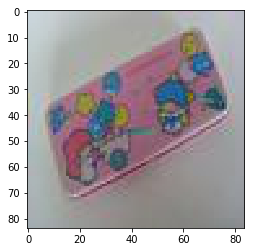

In [52]:
temp = support[1][1]
plt.imshow(temp)

In [54]:
temp = np.array(temp)*255.0
temp1 = Image.fromarray(np.uint8(temp))

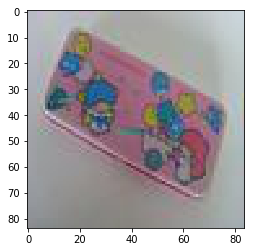

In [55]:
temp2 = Flip(temp1, "LEFT_RIGHT")
plt.imshow(temp2)

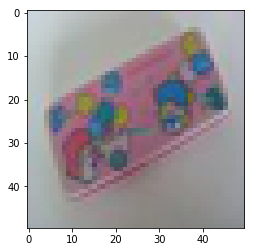

In [57]:
temp2 = Resize(temp1, 50,50, "BICUBIC")
plt.imshow(temp2)

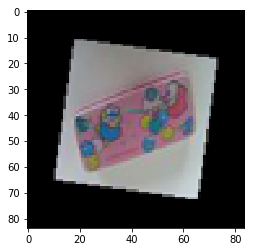

In [60]:
temp2 = RotateRange(temp1, 0,350)
plt.imshow(temp2)

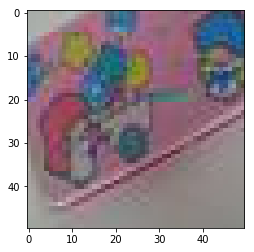

In [71]:
temp2 = Crop(temp1, 50,50, False)
plt.imshow(temp2)

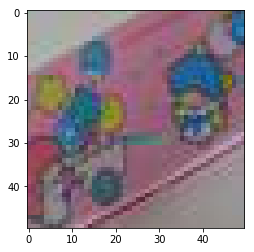

In [70]:
temp2 = Crop(temp1, 50,50, True)
plt.imshow(temp2)

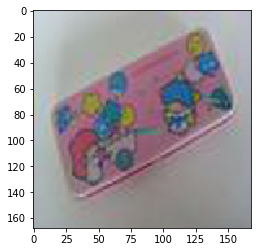

In [73]:
temp2 = Scale(temp1,2)
plt.imshow(temp2)

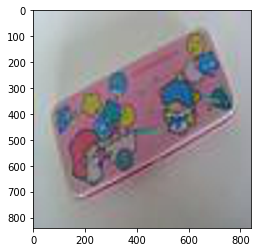

In [74]:
temp2 = Scale(temp1,10)
plt.imshow(temp2)

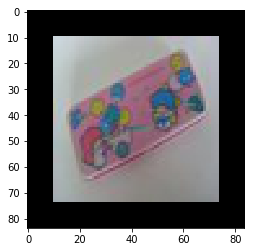

In [78]:
temp2 = Zoom(temp1,-1,1)
plt.imshow(temp2)

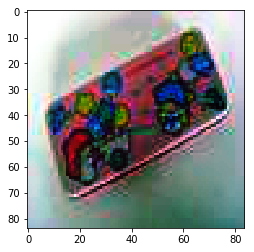

In [79]:
temp2 = HistogramEqualisation(temp1)
plt.imshow(temp2)

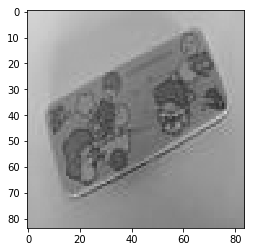

In [82]:
temp2 = Greyscale(temp1)
plt.imshow(temp2)

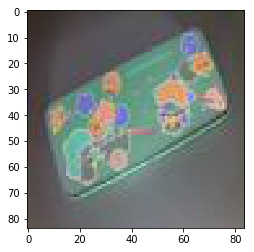

In [83]:
temp2 = Invert(temp1)
plt.imshow(temp2)

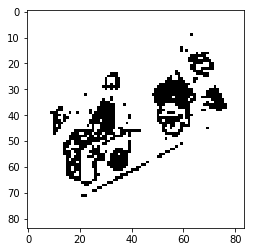

In [88]:
temp2 = BlackAndWhite(temp1,100)
plt.imshow(temp2)

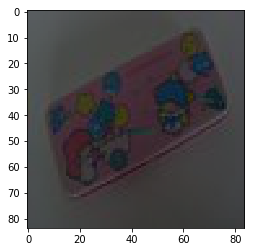

In [92]:
temp2 = RandomBrightness(temp1,0,0.5)
plt.imshow(temp2)

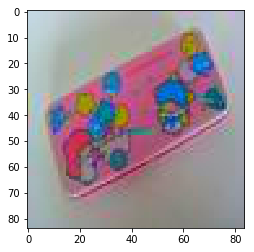

In [94]:
temp2 = RandomColor(temp1,0,2)
plt.imshow(temp2)

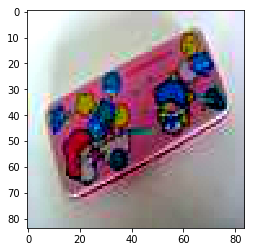

In [96]:
temp2 = RandomContrast(temp1,0,10)
plt.imshow(temp2)